## Evaluate Trained Robot Policy Model and Visualize

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import torch

import matplotlib.pyplot as plt

from typing import List
from tqdm import tqdm

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import common, constants
from utils.config import Config
from utils.dataset_loader import PolicyDatasetLoader

from optimization.updater import Updater
from optimization.functions import setup_config, get_directories, load_policy
from optimization.functions import read_each_loader, convert_sample_2_df, trajectory_estimation

from models.policy_model import RobotPolicy

# Initialization

In [2]:
# available evaluating machine
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)

# setup hyperparameters
configs = setup_config(device=device)

# create and return preliminary base paths
json_paths, results_path = get_directories(parent_directory=parent_directory,
                                           data_folder_name=constants.TEST_COLLECTION_DATE)

Evaluating Device:  cpu
Current Time:  Feb_02_2024-11_56_13


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Evaluating Device: ", device)
configs.device = device

Evaluating Device:  cpu


In [4]:
policy_network = RobotPolicy(state_size=configs.state_size,
                             hidden_size=configs.hidden_size,
                             out_size=configs.action_size,
                             log_std_min=configs.policy_log_std_min,
                             log_std_max=configs.policy_log_std_max,
                             log_std_init=configs.policy_log_std_init,
                             device=configs.device)

In [5]:
# load test demonstrations dataset
all_test_data = PolicyDatasetLoader(demo_data_json_paths=json_paths)


================== Policy Dataset Loader ==================

Number of Trajectories:  5
Each Trajectory Length:  20
Full Demo Dataset Size:  107


In [6]:
validation_loader = torch.utils.data.DataLoader(all_test_data,
                                                batch_size=1,
                                                shuffle=False,
                                                num_workers=configs.num_workers)

# Functions

In [7]:
def plt_2D_plotting(df: pd.DataFrame,
                    column_names: List[str],
                    x_axis_name: str,
                    y_axis_name: str,
                    x_label_name: str,
                    title_label_name: str) -> None:
    
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input 'df' must be a pandas DataFrame.")
    if not isinstance(column_names, list) or not all(isinstance(name, str) for name in column_names):
        raise TypeError("Input 'column_names' must be a list of strings.")
    if not all(name in df.columns for name in column_names):
        raise ValueError("Invalid column name(s) for column_names.")
    if not all(isinstance(label, str) for label in [x_axis_name, y_axis_name, title_label_name]):
        raise TypeError("Axis labels and title must be strings.")

    for column_name in column_names:
        if column_name not in df.columns:
            raise ValueError(f"Invalid column name: {column_name}")

    if len(column_names) not in [1, 2]:
        raise ValueError("Invalid number of columns to plot. Must be 1 or 2.")

    if not isinstance(x_axis_name, str) or not isinstance(y_axis_name, str):
        raise TypeError("Axis names must be strings.")
    if not isinstance(x_label_name, str):
        raise TypeError("Column name for x axis must be string.")
    if not isinstance(title_label_name, str):
        raise TypeError("Title must be a string.")
    
    for column_name in column_names:
        plt.scatter(df[x_label_name], df[column_name],
                    label=column_name)
    
    if len(column_names) == 2:
        mae_avg = np.mean(np.abs(df[column_names[0]] - df[column_names[1]]))
        mae_max = np.max(np.abs(df[column_names[0]] - df[column_names[1]]))
        
        error_text = f"Avg. MAE = {mae_avg:.5f} m\nMax. MAE = {mae_max:.5f} m"
        
        plt.text(0.95, 0.05,
                 error_text,
                 transform=plt.gca().transAxes,
                 verticalalignment="bottom",
                 horizontalalignment="right",
                 bbox=dict(facecolor="white", alpha=0.8))
    
    plt.xlabel(x_axis_name)
    plt.ylabel(y_axis_name)
    plt.title(title_label_name)
    
    plt.legend(loc="upper right")
    
    plt.show()

# Test

In [14]:
# folder name where parameters are located ("results / policy_network_params / loading_folder_name")
loading_folder_name = "Feb_01_2024-17_35_08"

In [15]:
params_name = "policy_network_epoch_50_loss_1_01136.pt"

In [16]:
# location of the trained model parameters (make sure that the folder exists where model is trained priorly)
model_folder_path = os.path.join(results_path,
                                 "policy_network_params",
                                 loading_folder_name)

In [17]:
model_path = os.path.join(model_folder_path,
                          params_name)

In [18]:
# set trained parameters to neural network
policy_network = load_policy(policy_network=policy_network,
                             model_path=model_path)

In [19]:
# set model to evaluation mode
for param in policy_network.parameters():
    param.requires_grad = False
policy_network = policy_network.eval()

In [20]:
updater = Updater(configs=configs,
                  policy_network=policy_network)

## Test with Only One Sample from Validation Set

In [21]:
sample_index = 0

In [25]:
evaluation_sample = all_test_data[sample_index]

In [26]:
input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                              sample_data=evaluation_sample)

In [27]:
# add a batch dimension by unsqueezing
action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state.unsqueeze(0),
                                                                                                                          is_inference=True)

In [28]:
# multivariate Gaussian negative log-likelihood loss function
nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                  y_pred=action_mu_and_std)

In [30]:
real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                            norm_value_list=all_test_data.state_norms)

In [31]:
real_action_output = common.denormalize_action(action_norm=output_action.unsqueeze(0).numpy(),
                                               norm_range_list=all_test_data.action_norms)[0]

In [32]:
real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                             norm_range_list=all_test_data.action_norms)[0]

## Run Through All Samples in a Trajectory for Every Trajectory

In [33]:
# initialize an empty list to store dataframes
trajectory_dataframes = []
df = pd.DataFrame()

In [34]:
# initialize variables to keep track of the current trajectory index and dataframes
current_trajectory_index = 0

In [37]:
for sample_data in tqdm(validation_loader):
    
    input_state, output_action, trajectory_index, state_number = read_each_loader(configs=configs,
                                                                                  sample_data=tuple(sample_data))
    action_pred, action_std, action_log_prob, action_entropy, action_mu_and_std, action_dist = policy_network.estimate_action(state=input_state,
                                                                                                                              is_inference=True)
    nll_loss = updater.multivariate_gaussian_nll_loss(y_true=output_action,
                                                      y_pred=action_mu_and_std)
    
    real_state_input = common.denormalize_state(state_norm=input_state.numpy(),
                                                norm_value_list=all_test_data.state_norms)
    real_action_output = common.denormalize_action(action_norm=output_action.numpy(),
                                                   norm_range_list=all_test_data.action_norms)
    real_action_pred = common.denormalize_action(action_norm=action_pred.detach().numpy(),
                                                 norm_range_list=all_test_data.action_norms)
    
    # validaton dataset sampling is done with size of one
    trajectory_index = int(trajectory_index[0].item())
    state_number = int(state_number[0].item())
    
    # store every important detail in the dataframe (only take zero index values, because validation dataset batch size is taken as 1)
    sample_df = convert_sample_2_df(input_state=input_state.squeeze(0),
                                    real_state_input=real_state_input[0],
                                    output_action=output_action.squeeze(0),
                                    real_action_output=real_action_output[0],
                                    action_log_prob=action_log_prob.squeeze(0),
                                    action_pred=action_pred.squeeze(0),
                                    action_std=action_std.squeeze(0),
                                    real_action_pred=real_action_pred[0],
                                    trajectory_index=trajectory_index,
                                    state_number=state_number,
                                    nll_loss=nll_loss.item())
    
    # check if the trajectory index has changed
    if trajectory_index == current_trajectory_index:
        
        if len(df) != 0:
            df = pd.concat([df, sample_df],
                           ignore_index=True)
        else:
            df = sample_df.copy(deep=True)
    
    else:
        # append the dataframe to the list
        trajectory_dataframes.append(df)
        
        # create a new dataframe for each trajectory_index
        df = sample_df.copy(deep=True)
        
        # update the current_trajectory_index
        current_trajectory_index = trajectory_index

if len(trajectory_dataframes) == 0:
    trajectory_dataframes.append(df)

100%|███████████████████████████████████████████████████████████████████████████████| 107/107 [00:00<00:00, 455.28it/s]


In [40]:
action_1_columns = [constants.ACTION_PREDICTION_DENORMALIZED_NAME + "_1",
                    constants.ACTION_DENORMALIZED_LABEL_NAME + "_1"]
action_1_title_name = "Prediction vs. Actual End-Effector X-Axis Position"
action_1_y_axis_name = "X-Axis Location [m]"

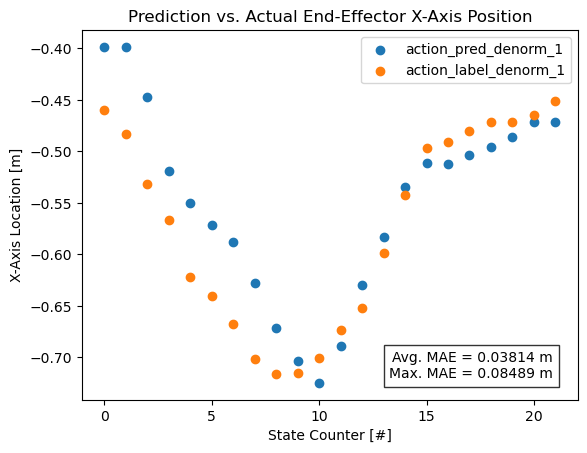

In [41]:
plt_2D_plotting(df=trajectory_dataframes[-1],
                column_names=action_1_columns,
                x_axis_name="State Counter [#]",
                y_axis_name=action_1_y_axis_name,
                x_label_name=constants.STATE_NUMBER_COLUMN,
                title_label_name=action_1_title_name)

## Get Estimated Next States while Applying Trained Policy Model Action

In [44]:
# index location where the each trajectory starts in the dataframe
traj_start_index = 0

trajectory_estimation(configs=configs,
                      data_loader=all_test_data,
                      policy_network=policy_network,
                      trajectory_length=constants.TRAJECTORY_SIZE,
                      traj_start_index=traj_start_index,
                      is_inference=True)


state_number :  0
initial_state_location :  [-0.26709259 -0.4246552   0.64906478]
action_denorm_label :  [-0.26709259 -0.4246552   0.64906478]
action_denorm_prediction :  [-0.3332051  -0.39052999  0.65289235]
current_state_denorm_estimation :  [0.93902451 1.45202374 0.         0.81869459]
next_state_denorm_label :  [0.79648093 1.4506016  0.         0.81756478]

state_number :  1
initial_state_location :  [-0.26709259 -0.4246552   0.64906478]
action_denorm_label :  [-0.34192443 -0.37014949  0.68653703]
action_denorm_prediction :  [-0.45644534 -0.31101978  0.66334271]
current_state_denorm_estimation :  [0.83659017 1.4220525  0.07449862 0.82139236]
next_state_denorm_label :  [0.83965979 1.42525644 0.09987415 0.85503703]

state_number :  2
initial_state_location :  [-0.26709259 -0.4246552   0.64906478]
action_denorm_label :  [-0.43146205 -0.28935647  0.71655345]
action_denorm_prediction :  [-0.3941077  -0.24293518  0.64648604]
current_state_denorm_estimation :  [0.91770786 1.36743104 0.22

In [45]:
trajectory_dataframes[0][["state_label_denorm_1", "state_label_denorm_2", "state_label_denorm_3", "state_label_denorm_4",
                          "action_label_denorm_1", "action_label_denorm_2", "action_label_denorm_3",
                          "state_number", "trajectory_index"]]

,state_label_denorm_1,state_label_denorm_2,state_label_denorm_3,state_label_denorm_4,action_label_denorm_1,action_label_denorm_2,action_label_denorm_3,state_number,trajectory_index
0,0.939024507999,1.452023744583,0.000000000000,0.818694591522,-0.267092585564,-0.424655199051,0.649064779282,0,0
1,0.935088515282,1.450601577759,0.001626401092,0.817564785480,-0.341924428940,-0.370149493217,0.686537027359,1,0
2,0.869431972504,1.425256490707,0.100514486432,0.855037093163,-0.431462049484,-0.289356470108,0.716553449631,2,0
3,0.767269253731,1.382267236710,0.224093317986,0.885053396225,-0.494331836700,-0.233648300171,0.729912042618,3,0
4,0.685918271542,1.353698372841,0.308483242989,0.898412108421,-0.520271420479,-0.101873636246,0.721692085266,4,0
5,0.552497148514,1.256301164627,0.417564332485,0.890192210674,-0.569305300713,0.039206743240,0.706590652466,5,0
6,0.432081520557,1.159159660339,0.557644963264,0.875090658665,-0.590718746185,0.163246631622,0.664050817490,6,0
7,0.330860853195,1.055709004402,0.672380626202,0.832550764084,-0.589801788330,0.298777580261,0.597844123840,7,0
8,0.283888220787,0.928516507149,0.794996440411,0.766344249249,-0.568415880203,0.435436725616,0.560789108276,8,0
9,0.361915647984,0.828994750977,0.916810631752,0.729288995266,-0.530749797821,0.565332651138,0.495034933090,9,0
